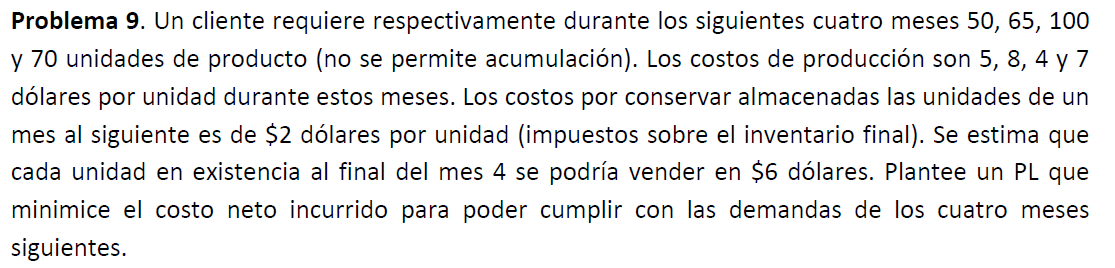

## Sets
T es el conjunto de meses (t = 1 es el mes 1, t = 2 es el mes 2, t = 3 es el mes 3, t = 4 es el mes 4)

In [12]:
import pyomo.environ as pe
import pyomo.opt as po

In [13]:
model = pe.ConcreteModel()

In [14]:
model.T = pe.RangeSet(1,4)

## Parameters

PV es el precio de venta por unidad en existencia al final del mes cuatro (dolar/unidad)\
Cpt es el costo de producción por unidad en el mes t (dolar/unidad)\
Ch es el costo de inventario de cada mes por unidad (dolar/unidad)\
Demt es la cantidad de unidades demandadas del artículo i en el mes t (unidad)

In [15]:
PV = 6
Dem = {1: 50, 2: 65, 3: 100, 4: 70}
Cp = {1: 5, 2: 8, 3: 4, 4: 7}
Ch = 2

In [16]:
model.PV = pe.Param(initialize = PV) #Precio de venta
model.Dem = pe.Param(model.T, initialize = Dem) #Demanda
model.Cp = pe.Param(model.T, initialize = Cp) #Costo de producción
model.Ch = pe.Param(initialize = Ch) #Costo de inventario

## Variables
Qpt es la cantidad de unidades a producir en el mes t\
Qht es la cantidad de unidades en inventario en el mes t

In [17]:
model.Qp = pe.Var(model.T, domain = pe.NonNegativeReals)
model.Qh = pe.Var(model.T, domain = pe.NonNegativeReals)

## Objective

In [18]:
Z = sum(model.Cp[t] * model.Qp[t] + model.Ch * model.Qh[t] for t in model.T) - model.PV * model.Qh[4]
model.objective = pe.Objective(sense = pe.minimize, expr = Z)
model.objective.pprint()

objective : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : minimize : 5*Qp[1] + 2*Qh[1] + 8*Qp[2] + 2*Qh[2] + 4*Qp[3] + 2*Qh[3] + 7*Qp[4] + 2*Qh[4] - 6*Qh[4]


## Constraints

In [19]:
#Ecuación de inventario
model.eqInv = pe.ConstraintList()
for t in model.T:
    if t == 1:
        Inv_lhs = model.Qh[t]
        Inv_rhs = model.Qp[t] - model.Dem[t]
    else:
        Inv_lhs = model.Qh[t]
        Inv_rhs = model.Qh[t-1] + model.Qp[t] - model.Dem[t]    
    model.eqInv.add(Inv_lhs == Inv_rhs)
model.eqInv.pprint()

eqInv : Size=4, Index=eqInv_index, Active=True
    Key : Lower : Body                          : Upper : Active
      1 :   0.0 :          Qh[1] - (Qp[1] - 50) :   0.0 :   True
      2 :   0.0 :  Qh[2] - (Qh[1] + Qp[2] - 65) :   0.0 :   True
      3 :   0.0 : Qh[3] - (Qh[2] + Qp[3] - 100) :   0.0 :   True
      4 :   0.0 :  Qh[4] - (Qh[3] + Qp[4] - 70) :   0.0 :   True


## Solver

In [20]:
solver = po.SolverFactory('glpk')
results = solver.solve(model, tee = True)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmp91c25j1_.glpk.raw --wglp
 C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpthlscns9.glpk.glp --cpxlp C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpmyy1fmu4.pyomo.lp
Reading problem data from 'C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpmyy1fmu4.pyomo.lp'...
5 rows, 9 columns, 12 non-zeros
51 lines were read
Writing problem data to 'C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpthlscns9.glpk.glp'...
42 lines were written
GLPK Simplex Optimizer 5.0
5 rows, 9 columns, 12 non-zeros
Preprocessing...
3 rows, 4 columns, 6 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 3
*     0: obj =   1.660000000e+03 inf =   0.000e+00 (2)
*     2: obj =   1.525000000e+03 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.0 

In [21]:
for t in model.T:
    print(pe.value(model.Qp[t]))        
print(pe.value(model.objective))

115.0
0.0
170.0
0.0
1525.0


In [22]:
for t in model.T:
    print(pe.value(model.Qh[t]))        
print(pe.value(model.objective))

65.0
0.0
70.0
0.0
1525.0
